In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [6]:
INFOSYS= pd.read_csv("C://Users//asus//Desktop//Stock market prediction using Random forest//INFY.NS.csv")

INFOSYS = INFOSYS[['Date','Open', 'High', 'Low','Close','Adj Close']]
INFOSYS.head()

,Date,Open,High,Low,Close,Adj Close
0,2015-07-01,494.5,502.500000,493.000000,498.700012,415.561249
1,2015-07-02,499.5,500.700012,492.524994,494.000000,411.644745
2,2015-07-03,494.0,496.500000,491.000000,495.149994,412.603058
3,2015-07-06,492.5,494.000000,487.500000,491.649994,409.686493
4,2015-07-07,492.5,495.000000,489.500000,490.250000,408.519897


In [7]:
INFOSYS.describe()

,Open,High,Low,Close,Adj Close
count,1227.000000,1227.000000,1227.000000,1227.000000,1227.000000
mean,605.359984,611.994194,598.518723,605.161715,557.417386
std,103.981567,105.130168,103.068678,104.111674,118.345056
min,440.000000,443.799988,430.000000,436.700012,390.604187
25%,514.187500,519.762482,509.349991,513.974976,451.269745
50%,586.025024,592.450012,580.000000,585.950012,517.107422
75%,704.924988,711.725006,695.975006,704.262512,676.590088
max,843.299988,847.000000,835.049988,840.150024,810.035217


In [8]:
INFOSYS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1228 entries, 0 to 1227
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1228 non-null   object 
 1   Open       1227 non-null   float64
 2   High       1227 non-null   float64
 3   Low        1227 non-null   float64
 4   Close      1227 non-null   float64
 5   Adj Close  1227 non-null   float64
dtypes: float64(5), object(1)
memory usage: 57.7+ KB


In [9]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import plot

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [10]:
layout = go.Layout(
    title='STOCK PRICE OF INFOSYS',
        xaxis=dict(
            title='date',
            titlefont=dict(
                family='Courier New, monospace',
                size=18,
                color='blue'
            )
        ),
        yaxis=dict(
            title='Price',
            titlefont=dict(
                family='Courier New, monospace',
                size=18,
                color='red'
        )
    )
)
INFOSYS_DATA = [{'x':INFOSYS['Date'], 'y':INFOSYS['Close']}]
plot = go.Figure(data=INFOSYS_DATA, layout=layout)

In [11]:
iplot(plot)

In [12]:
INFOSYS['Open-Close']= INFOSYS.Close - INFOSYS.Open
INFOSYS['High-Low']  = INFOSYS.High - INFOSYS.Low
INFOSYS = INFOSYS.dropna()
X= INFOSYS[['Open-Close', 'High-Low']]
X.head()

,Open-Close,High-Low
0,4.200012,9.500000
1,-5.500000,8.175018
2,1.149994,5.500000
3,-0.850006,6.500000
4,-2.250000,5.500000


In [13]:
Y= np.where(INFOSYS['Close'].shift(-1)>INFOSYS['Close'],1,-1)

In [14]:
split_percentage = 0.8
split = int(split_percentage*len(INFOSYS))

X_train = X[:split]
Y_train = Y[:split]

X_test = X[split:]
Y_test = Y[split:]

In [15]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [16]:
scores = []

for num_trees in range(1,41):
    clf = RandomForestClassifier(n_estimators = num_trees)
    scores.append(cross_val_score(clf, X, Y, cv=10))

In [17]:
print(scores[0])

[0.55284553 0.53658537 0.46341463 0.51219512 0.48780488 0.5203252
 0.51219512 0.48360656 0.45081967 0.45081967]


In [18]:
print(scores[1])

[0.58536585 0.45528455 0.48780488 0.57723577 0.47154472 0.4796748
 0.44715447 0.51639344 0.53278689 0.48360656]


In [19]:
rfc = RandomForestClassifier(n_estimators=16)

In [20]:
rfc.fit(X_train, Y_train)

RandomForestClassifier(n_estimators=16)

In [21]:
rfc_pred = rfc.predict(X_test)

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

In [23]:
print(classification_report(Y_test, rfc_pred))

              precision    recall  f1-score   support

          -1       0.40      0.46      0.43       116
           1       0.45      0.39      0.42       130

    accuracy                           0.42       246
   macro avg       0.42      0.42      0.42       246
weighted avg       0.43      0.42      0.42       246



In [24]:
print(confusion_matrix(Y_test, rfc_pred))

[[53 63]
 [79 51]]


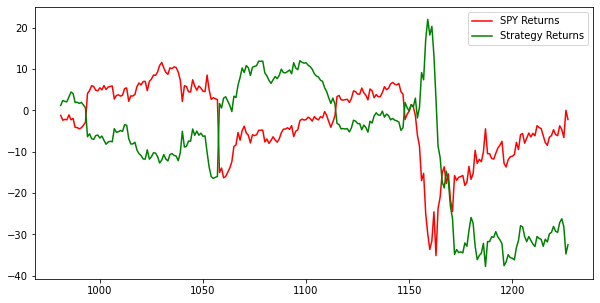

In [25]:
INFOSYS['Predicted_Signal'] = rfc.predict(X)

INFOSYS['SPY_returns'] = np.log(INFOSYS['Close']/INFOSYS['Close'].shift(1))
Cumulative_SPY_returns = INFOSYS[split:]['SPY_returns'].cumsum()*100
 
INFOSYS['Startegy_returns'] = INFOSYS['SPY_returns']* INFOSYS['Predicted_Signal'].shift(1)
Cumulative_Strategy_returns = INFOSYS[split:]['Startegy_returns'].cumsum()*100

plt.figure(figsize=(10,5))
plt.plot(Cumulative_SPY_returns, color='r',label = 'SPY Returns')
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
plt.legend()
plt.show()

In [26]:
Std = Cumulative_Strategy_returns.std()
Sharpe = (Cumulative_Strategy_returns-Cumulative_SPY_returns)/Std
Sharpe = Sharpe.mean()
print ('Sharpe ratio: %.2f'%Sharpe )

Sharpe ratio: -0.34


In [27]:
model = rfc.fit(X_train, Y_train)
model = rfc.fit (X_train,Y_train)

In [28]:
probability = model.predict_proba(X_test)
print(probability)

[[0.6875 0.3125]
 [0.8125 0.1875]
 [0.     1.    ]
 [0.25   0.75  ]
 [0.3125 0.6875]
 [0.75   0.25  ]
 [0.1875 0.8125]
 [0.375  0.625 ]
 [0.375  0.625 ]
 [0.     1.    ]
 [0.9375 0.0625]
 [0.8125 0.1875]
 [0.625  0.375 ]
 [0.25   0.75  ]
 [0.375  0.625 ]
 [0.5    0.5   ]
 [0.3125 0.6875]
 [0.5625 0.4375]
 [0.8125 0.1875]
 [0.8125 0.1875]
 [0.25   0.75  ]
 [0.125  0.875 ]
 [0.375  0.625 ]
 [0.0625 0.9375]
 [0.5    0.5   ]
 [0.875  0.125 ]
 [0.375  0.625 ]
 [0.5    0.5   ]
 [0.4375 0.5625]
 [0.6875 0.3125]
 [0.0625 0.9375]
 [0.3125 0.6875]
 [0.3125 0.6875]
 [0.8125 0.1875]
 [0.625  0.375 ]
 [0.     1.    ]
 [0.4375 0.5625]
 [0.5625 0.4375]
 [0.     1.    ]
 [0.6875 0.3125]
 [0.875  0.125 ]
 [0.3125 0.6875]
 [0.875  0.125 ]
 [0.1875 0.8125]
 [0.5625 0.4375]
 [0.75   0.25  ]
 [0.6875 0.3125]
 [0.4375 0.5625]
 [0.0625 0.9375]
 [0.625  0.375 ]
 [0.5625 0.4375]
 [0.125  0.875 ]
 [0.6875 0.3125]
 [0.625  0.375 ]
 [0.4375 0.5625]
 [0.3125 0.6875]
 [0.6875 0.3125]
 [0.6875 0.3125]
 [0.8125 0.187

In [29]:
predicted = rfc.predict(X_test)

In [30]:
from sklearn import metrics

In [31]:
print(metrics.confusion_matrix(Y_test, predicted))

[[54 62]
 [69 61]]


In [32]:
print(metrics.classification_report(Y_test, predicted))

              precision    recall  f1-score   support

          -1       0.44      0.47      0.45       116
           1       0.50      0.47      0.48       130

    accuracy                           0.47       246
   macro avg       0.47      0.47      0.47       246
weighted avg       0.47      0.47      0.47       246



In [33]:
print(model.score(X_train,Y_train))

0.9949031600407747


In [35]:
dataFrame = pd.DataFrame(Y_test,predicted)


In [36]:
dataFrame

,0
-1,-1
-1,1
1,-1
1,1
1,-1
...,...
-1,-1
1,-1
-1,1
-1,-1


In [37]:
dframe = pd.DataFrame({'Actual Price':Y_test, 'Predicted Price' : predicted})

In [38]:
sd=dframe.sort_values(by='Actual Price')

In [39]:
sd['Actual Price']

0     -1
134   -1
135   -1
138   -1
141   -1
      ..
48     1
47     1
46     1
52     1
40     1
Name: Actual Price, Length: 246, dtype: int32

In [40]:
print(sd) 

     Actual Price  Predicted Price
0              -1               -1
134            -1                1
135            -1               -1
138            -1                1
141            -1                1
..            ...              ...
48              1                1
47              1                1
46              1               -1
52              1               -1
40              1               -1

[246 rows x 2 columns]


In [41]:
dframe.head(20).sort_values(by='Actual Price')

,Actual Price,Predicted Price
0,-1,-1
17,-1,-1
16,-1,1
15,-1,-1
8,-1,1
7,-1,1
19,-1,-1
4,-1,1
2,-1,1
6,-1,1


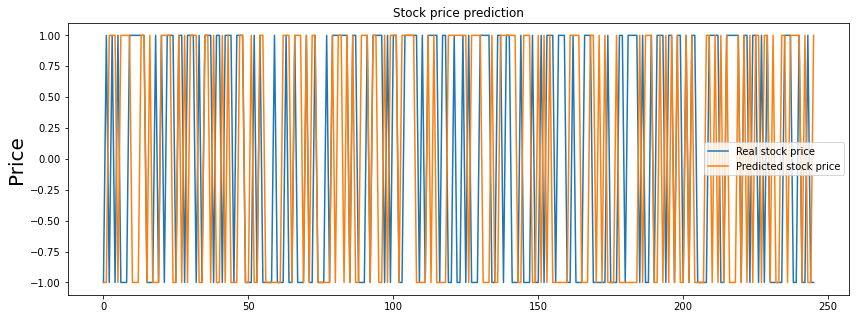

In [42]:
plt.figure(figsize=(14,5))
plt.ylabel('Price', fontsize=20)
plt.title("Stock price prediction")
plt.plot(pred_df)
plt.legend(['Real stock price', 'Predicted stock price'])
plt.show()